## This notebook builds a probabilistic model with Pymc3 to extend the MSqRob ridge regression model
https://www.ncbi.nlm.nih.gov/pubmed/28391044
$$
y_{ijkl} = \beta_{ij}^{treatment} + \beta_{ik}^{peptide} + \beta_{il}^{run} + \epsilon_{in}
$$

where $y$ stands for the $log_2$-transformed intensity of each peptide $k$ in run $l$ and condition $j$ that belong to protein $i$. $n$ is the $n^{th}$ peptide and $\epsilon$ is an noise term following a normal distribution with $mu$ = 0 and sigma $\sigma_i$ specific to the protein.
Each $\beta$ models a different effect on the final intensity measurement. The treatment effect \beta^{treatment} can be regarded as an estimate of the $\log_2$ protein quantity. Thus, $\beta_{ij}^{treatment A} - \beta_{ij}^{treatment B}$ is an estimate of the $log_2$ fold change of protein $i$ between conditions A and B.

Independent ridge regression models are built for all N peptides under protein $i$.

In this notebook, the fold change of the proteins detected in the MaxLFQ proteomebenchmark dataset: https://www.ebi.ac.uk/pride/archive/projects/PXD000279 is modeled in a similar way with a new extension.

The peptides.txt file from MaxQuant was read in R and preprocessed with MSqRob preprocess_MaxQuant().

Sequence features are extracted from each peptide to better capture the sequence variability inherent to each peptide.
The sequence features were extracted using the protr package in R using extractAPAAC(), which yields a numeric vector of 32 features for each peptide, independent of length.
Additionally to these 3 features, the number of missed cleavages of the peptide, and an integer encoding the neighboring residues of the peptide in the protein were added to the features, giving 35 features in total.

The sequence features are used to model the peptide effect \beta_{ik}^{peptide}.

$$
\beta_{ik}^{peptide} = \theta * features_{ik}
$$

which multiplies the intensities $y$ in the ridge regression model above, rendering a new model:

$$
y_{ijkln} = \beta^{treatment}_{ij} \beta_{ik}^{peptide} + + \beta_{il}^{run} + \epsilon_{in}
$$


In [438]:
import pymc3 as pm
import theano

In [439]:
import pandas as pd
import os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(123)
import seaborn as sns
sns.set_style('whitegrid')

In [421]:
# %load MSBay.py
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from theano import shared
import shutil
import os
from exp_annot_funcs import *
import sys


class MSBay:

    "Compile a MS-Bay model, load data into it and infer the posterior"

    def __init__(self, data, features=None):
       self.data = data
       self.features = features

    def compile_model(self, n_peptides, hierarchical_center=False):


        if self.features is None:
             sequence=False
        elif isinstance(self.features, pd.DataFrame):
             sequence = True
        else:
             sys.exit("Please set features to either None or a pd.DataFrame")


        self.observed_sh  = shared(np.array([0.,]*6*n_peptides))
        self.feats_sh  = shared(np.array([[0.,]*9,]*n_peptides))
        self.x_treat_sh  = shared(np.array([[0.,]*2,]*6*n_peptides))
        self.x_pep_sh  = shared(np.array([[0.,]*n_peptides,]*6*n_peptides))
        self.x_run_sh  = shared(np.array([[0.,]*6,]*6*n_peptides))
        self.x_estimate_sh  = shared(np.array([[0.,]*2,]*1))
     
        # The number of proteins in this model is always one
        # i.e this model is fitted protein-wise
        n_prots = 1
        # The number of features is set to 9 for now
        # All peptides have 9 features, stored in feats_shared
        n_features = 9
        
    
        with pm.Model() as model:
               
            # Build a hyerarchical linear model of
            # log2(MS1 intensities) by accounting for:
    
                 # Peptide effect
                 # Run (batch) effect
                 # Treatment effect
                 # Remaining random effects
    
            # The difference in treatment effects is an estimate of the log2FC
    
    
            # Set a prior on the intercept
            intercept = pm.Normal("intercept", 22, 1)
            
            # Set a prior on the remaining random effects
            sigma = pm.HalfNormal('sigma', 1)
    
            ## Set priors on the peptide effect
            ################################################
            sigma_pep = pm.HalfNormal('sigma_pep', 1)
    
            # Not using the sequence
            if not sequence:
                mu_pep = pm.Normal('mu_pep', mu=0, sd=sigma_pep, shape=(n_peptides, 1))
    
            # Using the peptide sequence
            else: 
                # sequence based modelling
                mu_theta = pm.Normal('theta_generic', 0, sigma_pep, shape = 1)
                theta = pm.Normal('theta', mu_theta, sigma_pep, shape = (n_features, 1))    # 9x1
                theta_inter = pm.Normal('theta_inter', mu_theta, sigma_pep, shape = 1)
                mu_pep = pm.Deterministic("mu_pep", theta_inter + self.feats_sh.dot(theta)) # n_peptidesx1
    
    
            ## Set priors on the treatment and run effects
            ################################################    
            sigma_treat = pm.HalfNormal('sigma_treat', 1)
            mu_treat = pm.Normal('mu_treat', 0, sigma_treat)
            sigma_run = pm.HalfNormal('sigma_run', 1)
            mu_run = pm.Normal('mu_run', 0, sigma_run)
    
            # Standard implementation of the hyerarchies
            if hierarchical_center:
                pep = pm.Normal("pep", mu_pep, sigma_pep) # n_peptidesx1
                treat = pm.Normal('treat', mu_treat, sigma_treat, shape = (n_prots*2, 1))
                run = pm.Normal('run', mu_run, sigma_run, shape = (n_prots*6, 1))
    
            # Reparametrization to escape funnel of hell as noted in
            # http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/
            else:
                pep_offset = pm.Normal("pep_offset", mu=0, sd=1, shape = (n_peptides, 1))
                pep = pm.Deterministic("pep", mu_pep + pep_offset * sigma_pep)
                treat_offset = pm.Normal("treat_offset", mu=0, sd=1, shape=(n_prots*2, 1))
                treat = pm.Deterministic("treat", mu_treat + treat_offset*sigma_treat)
                run_offset = pm.Normal("run_offset", mu=0, sd=1, shape=(n_prots*6, 1))
                run = pm.Deterministic("run", mu_run + run_offset*sigma_run)
    
    
            # Model the effect for all peptides
            # The sh variables consist of -1,0,1 matrices telling pymc3
            # which parameters shall be used with each peptide
            # In practice, the "clone" each parameter to fit the shape of observed_sh
            # observed_sh is a n_peptides*6x1 tensor
            # The first 6 numbers store the MS1 intensities of the first peptide in the 6 runs
            # The next 6 those of the second peptide, and so on
    
            #estimate = pm.Deterministic('estimate', pm.math.sum(self.x_estimate_sh.dot(treat), axis=1))
            estimate = pm.Deterministic('estimate', self.x_estimate_sh.dot(treat))
            treatment_effect = pm.Deterministic("treatment_effect", pm.math.sum(self.x_treat_sh.dot(treat), axis=1))
            peptide_effect = pm.Deterministic("peptide_effect", pm.math.sum(self.x_pep_sh.dot(pep), axis=1))
            run_effect = pm.Deterministic("run_effect", pm.math.sum(self.x_run_sh.dot(run), axis=1))
    
            # BIND MODEL TO DATA
            mu = pm.Deterministic("mu", 
                intercept + treatment_effect + peptide_effect + run_effect) #n_peptides*6x1
            if hierarchical_center:
                obs = pm.Normal("obs", mu, sigma, observed=self.observed_sh)
            else:
                obs_offset = pm.Normal("obs_offset", mu=0, sd=1, shape=(n_peptides*6,1))
                obs = pm.Normal("obs", mu+obs_offset*sigma, sigma, observed=self.observed_sh)
    
    
        print("Success: Model compiled")

        self.model = model
        return model
    
    def sample(self, model_name, n_draws=1000, n_chains=3, remove_backend=True):
    
        # Check working environment  
        if not os.path.isdir("traces") or not os.path.isdir("plots/traceplots"):
            msg = "Please create a traces dir and a plots/traceplots dir before running this code"
            raise Exception(msg)
    
        if remove_backend and os.path.isdir("traces/{}".format(model_name)):
            shutil.rmtree("traces/{}".format(model_name))
    
    
        with self.model:
            # Parameters of the simulation:
            # Number of iterations and independent chains.
            n_sim = n_draws*n_chains
    
            # Save traces to the Text backend i.e a folder called
            # model_name containing csv files for each chain
            trace_name = 'traces/{}'.format(model_name)
            db = pm.backends.Text(trace_name)
            trace = pm.sample(draws=n_draws, njobs=n_chains, trace=db,
                              tune=2000, nuts_kwargs=dict(target_accept=.95))
        
        # Save a traceplot 
        pm.traceplot(trace, varnames=["estimate"])
        traceplot = "plots/traceplots/{}.png".format(model_name)
        plt.savefig(traceplot)
        plt.close()
           
        return trace

    def fit(self, model_name, n_draws):

        with self.model:
            
            inference = pm.ADVI()
            # how can the trace be saved when using pm.fit??
            trace = pm.fit(n=n_draws, method=inference).sample()

        plt.plot(-inference.hist, alpha=.5)
        plt.legend()
        plt.ylabel('ELBO')
        plt.xlabel('iteration');
        plt.savefig("plots/ELBO/{}".format(model_name))
        plt.close()
        
        return trace
    
    def load_data(self, p, top=3):
    
        df = pd.DataFrame({"std": np.std(self.data.loc[self.data.protein == p,:].iloc[:,2:5].values, axis=1) + np.std(self.data.loc[self.data.protein == p,:].iloc[:,5:8].values, axis=1)})
        best_data = self.data.loc[self.data.protein == p,:].iloc[df.sort_values(by="std", ascending=True).iloc[:top,:].index,:]

        print(best_data)

        variables = create_variables(best_data, self.features, [p])
        observed, feats, x_treat, x_pep, x_run, x_estimate = variables

        self.observed_sh.set_value(observed)
        if feats is not None:
            self.feats_sh.set_value(feats)    

        self.x_treat_sh.set_value(x_treat)
        self.x_pep_sh.set_value(x_pep)
        self.x_run_sh.set_value(x_run)
        self.x_estimate_sh.set_value(x_estimate)


In [422]:
data = pd.read_csv("data/data.tsv", sep = "\t")
data['H1'] = data['H1'].astype(theano.config.floatX)
data['H2'] = data['H2'].astype(theano.config.floatX)
data['H3'] = data['H3'].astype(theano.config.floatX)
data['L1'] = data['L1'].astype(theano.config.floatX)
data['L2'] = data['L2'].astype(theano.config.floatX)
data['L3'] = data['L3'].astype(theano.config.floatX)
data.head().drop("taxon", axis=1)

,protein,H1,H2,H3,L1,L2,L3
0,P37108,28.181535,28.006834,28.006941,27.133594,27.969390,27.869266
1,Q96P70,26.121057,25.893423,26.436157,25.421240,25.719706,25.811642
2,Q9Y2U8,22.398509,23.542741,24.042266,25.124118,25.285598,25.008512
3,Q9BTD8-4;Q9BTD8-2;Q9BTD8-3;Q9BTD8,23.337153,22.611060,23.675084,19.519606,23.237510,22.601230
4,Q9P258,22.545124,20.359925,22.185649,21.836265,22.880450,21.577547


[0.8469232  0.08723227]
[754.54590515 242.1599028 ]


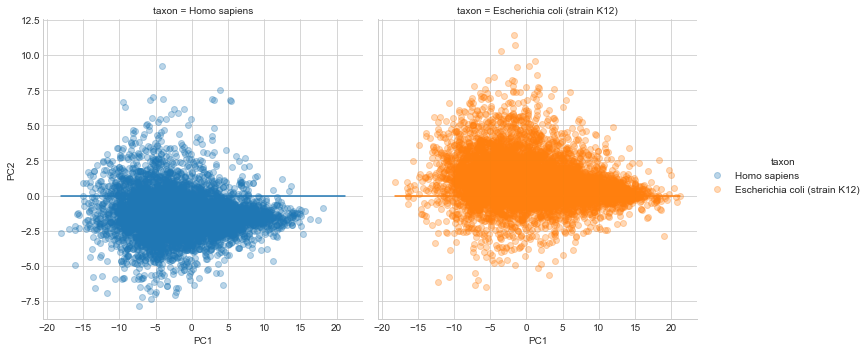

In [423]:
from sklearn.decomposition import PCA 
x = data.values[:,2:]
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
x_transformed = pca.transform(x)
pca_data = pd.DataFrame({"taxon": data.taxon, "PC1": x_transformed[:,0], "PC2": x_transformed[:,1]})
myPlot = sns.FacetGrid(col="taxon", hue='taxon', data=pca_data, size=5)
myPlot = myPlot.map(plt.scatter, "PC1", "PC2", alpha=0.3)
myPlot = myPlot.map_dataframe(plt.plot, [min(pca_data.PC1),max(pca_data.PC1)], [0, 0], 'r-').add_legend().set_axis_labels("PC1", "PC2")
plt.show()

In [424]:
x=np.mean(data[["H1","H2","H3"]].values, axis=1)
y=np.mean(data[["L1","L2","L3"]].values, axis=1)
# colors=["red", "blue"]
# for i, taxon in enumerate(["Escherichia coli (strain K12)", "Homo sapiens"]):
#     plt.scatter(x=x[data.taxon == taxon],y=y[data.taxon == taxon], c=colors[i],label=taxon, alpha=0.5)
# def abline(slope, intercept):
#     """Plot a line from slope and intercept"""
#     axes = plt.gca()
#     x_vals = np.array(axes.get_xlim())
#     y_vals = intercept + slope * x_vals
#     plt.plot(x_vals, y_vals, '--',color="green")
# abline(1,0)
# plt.legend()
# plt.show()


In [425]:
from numpy.linalg import norm
p1 = np.array([0,0])
p2 = np.array([1,1])
indices = [data.taxon == "Homo sapiens", data.taxon != "Homo sapiens"]
hsapiens_d, ecoli_d =np.array([[norm(np.cross(p2-p1, p1-p3))/norm(p2-p1) for p3 in zip(x[idx],y[idx])] for idx in indices])
print(np.mean(hsapiens_d))
print(np.mean(ecoli_d))

0.6005208785523234
1.6266920285619832


In [426]:
features = pd.read_csv("data/advanced_features.tsv", sep = "\t").iloc[:,1:]
features=features.iloc[data.index,:]
n_seq_feat = features.shape[1]
print("Number of sequence features {}".format(n_seq_feat))
n_prots = len(np.unique(data.protein))
print("Number of proteins {}".format(n_prots))
n_peptides = data.shape[0]
print("Number of peptides {}".format(n_peptides))
print("This is the first row of the features array:")
print(features.shape)
print(features.iloc[:1,:])
features.head()

Number of sequence features 9
Number of proteins 2850
Number of peptides 17107
This is the first row of the features array:
(17107, 9)
   aromaticity  composition_G  composition_K  composition_V  flexibility  \
0    -0.992459            1.0            0.0            0.0     1.648868   

   instability    length  mass_len_ratio        hm  
0       1.8288  1.286819       -2.053132 -1.516532  


,aromaticity,composition_G,composition_K,composition_V,flexibility,instability,length,mass_len_ratio,hm
0,-0.992459,1.0,0.0,0.0,1.648868,1.828800,1.286819,-2.053132,-1.516532
1,0.841374,1.0,1.0,0.0,-0.248549,-0.573767,-0.074351,-0.396156,-0.513330
2,-0.992459,1.0,0.0,0.0,0.804389,1.928472,-0.852162,1.468934,2.343718
3,-0.992459,1.0,1.0,1.0,-0.957520,0.058742,-0.657709,-1.121271,0.094526
4,-0.992459,1.0,1.0,1.0,-0.172332,-0.188579,0.120102,-1.097936,-1.934398


### Every protein has at least two peptides

In [427]:
counts0 = np.unique(data.protein, return_counts=True)
counts = np.unique(counts0[1], return_counts=True)
counts_df = pd.DataFrame(np.array([counts[0], counts[1]]).T, columns = ["n_peptides", "n_prots"])

In [529]:
counts_df

,n_peptides,n_prots
0,2,874
1,3,498
2,4,311
3,5,205
4,6,155
5,7,133
6,8,109
7,9,96
8,10,65
9,11,61


In [429]:
protein_counts = {str(c): counts0[0][counts0[1] == c] for c in np.unique(counts0[1])}
proteins = protein_counts[str(10)]
len(proteins)

65

In [430]:
n_peptides = 2
prots, counts = np.unique(data.protein, return_counts=True)
prots = prots[counts == n_peptides]
data.loc[data.protein.isin(prots).values & (data.taxon == "Homo sapiens"),:].sort_values("protein").head(10)

,protein,taxon,H1,H2,H3,L1,L2,L3
16655,A0AVT1;A0AVT1-2,Homo sapiens,22.263188,23.602635,20.509300,22.428874,22.885225,21.962187
10052,A0AVT1;A0AVT1-2,Homo sapiens,22.277391,23.686029,22.648932,22.740695,22.062961,22.033824
10644,A2A2V2;P42696,Homo sapiens,20.903820,21.592680,20.734299,20.149544,19.889008,20.710366
13567,A2A2V2;P42696,Homo sapiens,20.746078,20.708178,19.941346,20.997485,20.997830,20.989608
14440,A6NJ78,Homo sapiens,18.657179,19.746521,18.845613,17.107789,18.301264,18.059175
1120,A6NJ78,Homo sapiens,20.849497,20.339411,19.964939,16.527019,17.736745,19.317828
7338,A6NKE1;A6NDN0;O43617,Homo sapiens,23.476054,23.070923,23.436951,22.460990,23.561158,23.516771
9885,A6NKE1;A6NDN0;O43617,Homo sapiens,23.266137,24.041180,22.811627,22.617935,22.681639,22.714438
12952,B2WTI4;Q6NYC1-2;Q6NYC1;Q6NYC1-3,Homo sapiens,24.520133,24.524384,23.033370,23.639535,24.128018,22.681081
16332,B2WTI4;Q6NYC1-2;Q6NYC1;Q6NYC1-3,Homo sapiens,21.491354,22.193160,18.568001,20.550371,20.925931,20.001820


In [530]:
data.loc[data.protein=="O60437",:]

,protein,taxon,H1,H2,H3,L1,L2,L3
5175,O60437,Homo sapiens,28.741208,28.327403,29.313328,22.443365,21.071562,21.025061
13172,O60437,Homo sapiens,21.210564,21.021067,22.044736,16.351974,20.372308,19.784175


### Load data

In [477]:
msbay = MSBay(data, features=None)

### Instantiate model

In [478]:
n_peptides=3
top=5
p=protein_counts[str(n_peptides)][0]
model = msbay.compile_model(n_peptides=n_peptides)

Success: Model compiled


### Load data for specific protein

In [479]:
print(p)
msbay.load_data(p,top=top)

3it [00:00, 19478.19it/s]

A3KMH1-2;E2QRD0;A3KMH1-3;A3KMH1
                              protein         taxon         H1         H2  \
1140  A3KMH1-2;E2QRD0;A3KMH1-3;A3KMH1  Homo sapiens  22.743635  22.210564   
9161  A3KMH1-2;E2QRD0;A3KMH1-3;A3KMH1  Homo sapiens  21.723716  23.231443   
2941  A3KMH1-2;E2QRD0;A3KMH1-3;A3KMH1  Homo sapiens  21.439338  22.150505   

             H3         L1         L2         L3  
1140  20.213593  24.164153  23.423422  24.089825  
9161  19.926713  23.402366  22.793583  22.533360  
2941  24.262987  21.321521  20.898147  18.564804  
None
Shape of x_treat is 18, 2
Shape of x_pep is 18, 3
Shape of x_estimate is 1, 2


In [480]:
df=pd.DataFrame({"std": np.std(msbay.data.loc[msbay.data.protein == p,:].iloc[:,2:5].values, axis=1) + np.std(msbay.data.loc[msbay.data.protein == p,:].iloc[:,5:8].values, axis=1)})
best_data = msbay.data.loc[msbay.data.protein == p,:].iloc[df.sort_values(by="std", ascending=True).iloc[:top,:].index,:]
variables = create_variables(best_data, msbay.features, [p])
[e.shape  if e is not None else None for e in variables]

3it [00:00, 11244.78it/s]

None
Shape of x_treat is 18, 2
Shape of x_pep is 18, 3
Shape of x_estimate is 1, 2


[(18,), None, (18, 2), (18, 3), (18, 6), (1, 2)]

### Run model!!!!


In [481]:
# trace_nuts = msbay.sample(model_name=p,n_draws=1000, n_chains=3)

In [482]:
trace_advi = msbay.fit(model_name=p, n_draws=50000)

Average Loss = 610.93: 100%|██████████| 50000/50000 [00:38<00:00, 1314.31it/s]
Finished [100%]: Average Loss = 610.95
No handles with labels found to put in legend.


In [522]:
trace_advi["estimate"][0]

array([[-0.01299379]])

In [525]:
# os.mkdir("traces/{}".format(p))
df=pd.DataFrame({"estimate": trace_advi["estimate"][:,0,0]})
df.to_csv("traces/{}/chain-0.tsv".format(p))

In [ ]:
# traces=[]
# with model:
#     trace_name = "traces/{}".format(p)
#     print(trace_name)
#     trace = pm.backends.text.load(trace_name)
#     traces.append(trace)

In [483]:
pm.summary(trace_advi, varnames=["estimate"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
estimate__0_0,-0.036453,0.134145,0.0055,-0.258126,0.180247


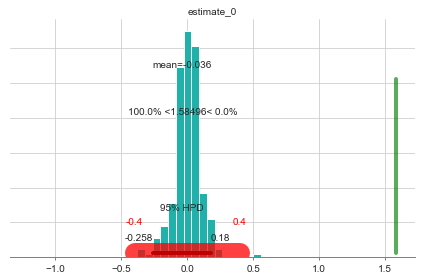

In [484]:
# pm.plot_posterior(trace_nuts, varnames=["estimate"], ref_val=np.log2(3), color='LightSeaGreen', rope=[-0.4, 0.4])
# plt.savefig("plots/posteriors/{}_nuts.png".format(p))
pm.plot_posterior(trace_advi, varnames=["estimate"], ref_val=np.log2(3), color='LightSeaGreen', rope=[-0.4, 0.4])
plt.savefig("plots/posteriors/{}_advi.png".format(p))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f8a2f0e80>,
      dtype=object)

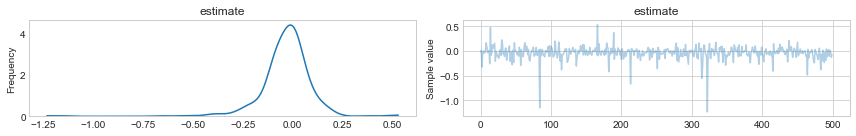

In [485]:
# pm.traceplot(trace_nuts, varnames=["estimate"])
pm.traceplot(trace_advi, varnames=["estimate"])

In [ ]:
from pymc3 import sample_ppc
with model:
    sim = sample_ppc(trace_advi, samples=500)["obs"]

In [ ]:
sim=sim[:,0,:]

In [ ]:
peps = list(map(lambda i: sim[:, (i*6):((i*6)+6)], range(n_peptides)))
estimates = list(map(lambda x: np.mean(x[:,:3], axis=1) - np.mean(x[:,3:6], axis=1), peps))
fig, ax = plt.subplots(1,n_peptides, figsize=(15,5))
[ax[i].hist(e) for i, e in enumerate(estimates)]
# [plt.hist(e, bins=30) for e in estimates]

In [ ]:
sim_transformed = pca.transform(np.vstack(peps))
sim_transformed
plt.scatter(sim_transformed[:,0], sim_transformed[:,1], label="Sim obs")
obs = data.loc[data.protein == p].iloc[:,2:]
obs_transformed = pca.transform(obs)
plt.scatter(obs_transformed[:,0], obs_transformed[:,1], c = "red", label="True obs")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

In [486]:
%load_ext rpy2.ipython
%R library(ggplot2); library(tidyr); library(ggalt); library(cowplot)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['cowplot', 'ggalt', 'tidyr', 'ggplot2', 'tools', 'RevoUtils',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U9')

In [572]:
%%R
make_dumbbell_plot <- function(MSBayQ, n_pep=NULL) {


    if (!is.null(n_pep)) MSBayQ <- MSBayQ[MSBayQ$n_peptides == n_pep,] %>% head
    p <- ggplot(data=MSBayQ, aes(x=hpd_2.5, xend=hpd_97.5, y = protein, color=Organism)) +
       geom_vline(xintercept=-0.4, col="red", linetype="dashed") +
       geom_vline(xintercept=0.4, col="red", linetype="dashed") +
       geom_vline(xintercept=log2(3), col="orange", linetype="dashed") +
       geom_dumbbell(size=0.75,
                     point.colour.l="#0e668b") +
    geom_point(aes(x=mean, y = protein)) +
        labs(x=NULL, 
             y=NULL, 
             title=paste0("Performance. Peptides= ", n_pep) 
#              subtitle="Pct Change: 2013 vs 2014", 
#              caption="Source: https://github.com/hrbrmstr/ggalt"
            ) +        
    theme(plot.title = element_text(hjust=0.5, face="bold"),
              plot.background=element_rect(fill="#f7f7f7"),
              panel.background=element_rect(fill="#f7f7f7"),
              panel.grid.minor=element_blank(),
              panel.grid.major.y=element_blank(),
              panel.grid.major.x=element_line(),
              axis.ticks=element_blank(),
              legend.position="top",
              panel.border=element_blank()) +
    xlab("log2FC 95% HDI")
    return(p)
}

make_error_hdi_interval_plot <- function(MSBayQ, n_pep=NULL) {
    if (!is.null(n_pep)) MSBayQ <- MSBayQ[MSBayQ$n_peptides == n_pep,]
    MSBayQ$true <- 0
    MSBayQ[MSBayQ$Organism == "Escherichia coli (strain K12)","true"] <- log2(3)
    print(cor(x=MSBayQ$`hpd_97.5` - MSBayQ$`hpd_2.5`, y=abs(MSBayQ$mean-MSBayQ$true)))
    ggplot(data = MSBayQ, mapping = aes(x = (`hpd_97.5` - `hpd_2.5`), y = abs(mean - true), col = Organism)) + geom_point()
    
}


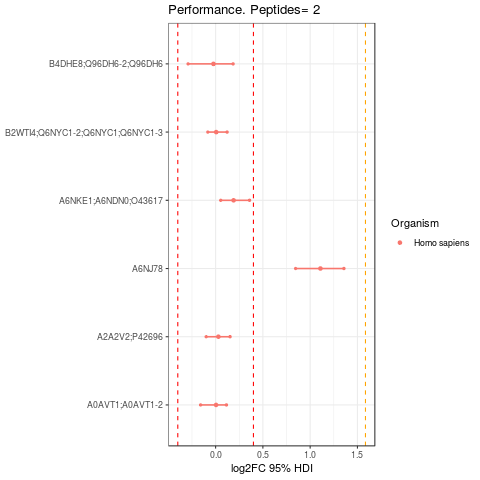

In [573]:
%%R
MSBayQ <- read.table("data/MSBayQ.tsv", header=T, sep = "\t")
colnames(MSBayQ)[1] <- "protein"
p1 <- make_dumbbell_plot(MSBayQ, 2)
ggsave("plots/performance.png")
p1 + theme_bw()

[1] "protein"    "Organism"   "hpd_2.5"    "hpd_97.5"   "mc_error"  
[6] "mean"       "n_peptides" "sd"        
[1] 0.2663262


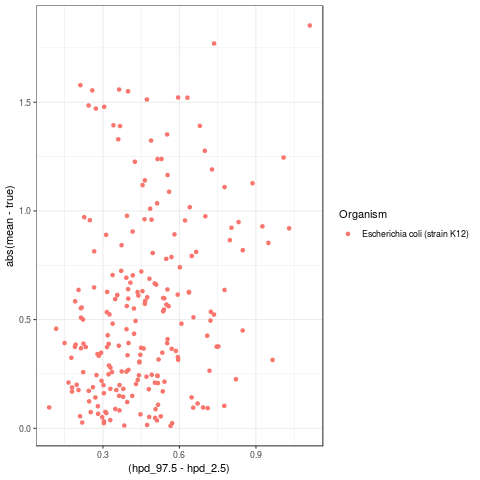

In [575]:
%%R
MSBayQ <- read.table("data/MSBayQ.tsv", header=T, sep = "\t")
colnames(MSBayQ)[1] <- "protein"
print(colnames(MSBayQ))
p1 <- make_error_hdi_interval_plot(MSBayQ[MSBayQ$Organism != "Homo sapiens",],3)
p1 + theme_bw()

In [578]:
model = msbay.compile_model(n_peptides=5)
!pwd

Success: Model compiled
/home/antortjim/MEGA/Master/Thesis/Code/model


In [580]:
with model:
    p = "P0AF50"
    trace_name = "traces/{}".format(p)
    trace = pm.backends.text.load(trace_name)
    pm.summary(trace, varnames=["estimate"])

ValueError: No files present in directory traces/P0AF50